In [59]:
import os
import sys
from tqdm import tqdm
import numpy as np
import torch
import h5py
import pandas as pd
import rdkit.Chem as Chem
from rdkit.Chem import Draw
import io
from PIL import Image
import hickle as hkl

In [60]:
os.chdir(r'/home/ubuntu/newdel/data_process')
import fingerprint
from MLP import Net

In [61]:
ROOT = '../'
# sys.path += [ROOT + '/../']

if not os.path.isdir('single_substructure_analysis'):
    os.mkdir('single_substructure_analysis')

def pathify(fname):
    return os.path.join('single_substructure_analysis', fname)

def save_png(data, out_path):
    bio = io.BytesIO(data)
    img = Image.open(bio)
    img.save(out_path, 'PNG')

In [62]:
FINGERPRINTS_FILENAME = 'TIGIT_trisython_smi_low_radius_3.h5' # should be in experiments folder
MODEL_PATH0 = os.path.join(ROOT, 'result/2022-06-21/MLP/', 'MLP_append_1_smi.pt')
state_dict = torch.load(MODEL_PATH0)
model = Net(2048,[256])
model.load_state_dict(state_dict)
model = model.eval()

In [63]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Arial') 
matplotlib.rc('text', usetex='false')

In [65]:
def charge(a):
    """Returns a SMARTS substring describing the atomic charge."""
    if a.GetFormalCharge() >= 0:
        return f'+{a.GetFormalCharge()}'
    return f'-{abs(a.GetFormalCharge())}'
def getMorganFingerprintAtomSymbols(mol):
    """Generate custom atomSymbols based on the specificity of an atom
    definition used by Morgan Fingerprints. Namely,
        - atom ID
        - degree
        - number of Hs
        - ring membership
        - charge
    These are based on getConnectivityInvariants from FingerprintUtil.cpp at
    https://github.com/rdkit/rdkit/blob/75f03412ef151a4dc14dfee986e29c3690a4c071/Code/GraphMol/Fingerprints/FingerprintUtil.cpp#L254
    """
    atomSymbols = []
    for a in mol.GetAtoms():
        atomSymbols.append(
            f'[#{a.GetAtomicNum()};D{a.GetDegree()};H{a.GetTotalNumHs()};R{mol.GetRingInfo().NumAtomRings(a.GetIdx())};{charge(a)}]')
    return atomSymbols

In [66]:
def GetWeightsForBit(bit_id): 
    """Returns 1) the differences in model predictions when the specified bit is masked for each fingerprint,
    2) the average of these differences.
    Returns -inf for the average if the specified bit is not set by any of the molecules.
    """
    indices = np.squeeze(np.where(x[:,bit_id]==1))
    x_hasbit = np.squeeze(x[indices, :])
    x_hasbit_masked = x_hasbit.copy()
    if x_hasbit.ndim == 1:
        x_hasbit_masked[bit_id] = 0
        x_hasbit_masked = x_hasbit_masked.reshape(-1,2048)
        print(x_hasbit_masked)
    else:
        x_hasbit_masked[:, bit_id] = 0
    basePreds = basePreds_all[indices]
    newPreds = np.squeeze(np.array(model(torch.FloatTensor(x_hasbit_masked)).detach().numpy(), dtype='float64'))
    weights = np.subtract(basePreds, newPreds)
    if x_hasbit.shape[0] != 0:
        avg_weight = np.sum(weights) / x_hasbit.shape[0] 
        return weights, avg_weight
    else: 
        return weights, -np.inf

In [67]:
def GetWeightsForSubstructure(weights, indices):
    """Returns 1) the molecule-level bit weights when the substructure of interest sets the bit,
    2) the average of these weights. 
    
    Parameters:
        - weights: molecule-level bit weights for a model and specific bit 
        - indices: indices in ::weights:: for the molecules with the substructure
    """
    weights_for_substructure = weights[indices]
    if len(indices) != 0:
        avg_weight = np.sum(weights_for_substructure) / len(indices)
    else:
        raise ValueError('No indices specified')
    return weights_for_substructure, avg_weight

In [68]:
def getFragmentForMolBit(smi, mol, mol_idx, atomSymbols, cpd_id, bit, info_all, submol_freq_distrib, 
                        smarts_to_smis, submol_to_cpd_indices, submol_to_bit, bits_to_draw):
    """Returns updated dictionaries and examples after searching for substructure(s) in the 
    specified molecule that set the specified bit.
    """
    molAdded = False
    examples = []
    for j, example in enumerate(info_all[mol_idx][bit]):
        atom = example[0]
        radius = example[1]
        env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom)
        atoms = set()
        for bidx in env:
            atoms.add(mol.GetBondWithIdx(bidx).GetBeginAtomIdx())
            atoms.add(mol.GetBondWithIdx(bidx).GetEndAtomIdx())
        if atoms:
            submol_smi = Chem.MolFragmentToSmiles(mol, atomsToUse=list(atoms), bondsToUse=env, 
                                            rootedAtAtom=atom, isomericSmiles=True, allBondsExplicit=True)
            submol_sm = Chem.MolFragmentToSmiles(mol, atomsToUse=list(atoms), atomSymbols=atomSymbols,
                                            bondsToUse=env, isomericSmiles=True, allBondsExplicit=True)
            if submol_sm not in submol_freq_distrib[bit]:
                print(f'cpd_id: {cpd_id}')
                print(f'SMILES string: {smi}')
                print(f'bit ID: {bit}')
                print(f'(atom, radius): {(atom, radius)}')
                print(f'molecular fragment (SMILES): {submol_smi}')
                print(f'molecular fragment (SMARTS): {submol_sm}')
                print()
                submol_freq_distrib[bit][submol_sm] = 1 
                if submol_sm not in smarts_to_smis:
                    smarts_to_smis[submol_sm] = [submol_smi]
                else:
                    smarts_to_smis[submol_sm].append(submol_smi)   
                if submol_sm not in submol_to_bit:
                    submol_to_bit[submol_sm] = [bit]
                else:
                    submol_to_bit[submol_sm].append(bit)       
                examples.append(j)
                submol_to_cpd_indices[submol_sm] = [mol_idx]
                if not molAdded:
                    bits_to_draw.append((cpd_id, mol, bit, info_all[mol_idx]))
                    molAdded = True
            else:
                submol_freq_distrib[bit][submol_sm] += 1
                submol_to_cpd_indices[submol_sm].append(mol_idx)
        else:
            atom_smi = mol.GetAtomWithIdx(atom).GetSmarts()
            atom_sm = Chem.MolFragmentToSmiles(mol, 
                        atomsToUse=atom,
                        atomSymbols=atomSymbols,
                        isomericSmiles=True, 
                        allBondsExplicit=True)
            if atom_sm not in submol_freq_distrib[bit]:
                print(f'cpd_id: {cpd_id}')
                print(f'SMILES string: {smi}')
                print(f'bit ID: {bit}')
                print(f'(atom, radius): {(atom, radius)}')
                print(f'atom: {atom_sm}')
                print()
                submol_freq_distrib[bit][atom_sm] = 1
                if atom_sm not in smarts_to_smis:
                    smarts_to_smis[atom_sm] = [atom_smi]
                else:
                    smarts_to_smis[atom_sm].append(atom_smi)
                if atom_sm not in submol_to_bit:
                    submol_to_bit[atom_sm] = [bit]
                else:
                    submol_to_bit[atom_sm].append(bit)
                examples.append(j)
                submol_to_cpd_indices[atom_sm] = [mol_idx]
                if not molAdded:
                    bits_to_draw.append((cpd_id, mol, bit, info_all[mol_idx]))
                    molAdded = True
            else:
                submol_freq_distrib[bit][atom_sm] += 1
                submol_to_cpd_indices[atom_sm].append(mol_idx)
    return submol_freq_distrib, smarts_to_smis, submol_to_cpd_indices, submol_to_bit, bits_to_draw, examples

In [69]:
DEVICE = None
if torch.cuda.is_available():
    DEVICE = 'cuda:0'

#  TIGIT (random split, seed 0)

## Load data

In [70]:
os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'
df_data = pd.read_csv(os.path.join(ROOT, 'data', 'train_data', 'TIGIT_trisython_smi_low.csv'))
tmp = df_data[-10000:]
df_data = df_data[:-10000:8]
df_data = pd.concat((df_data,tmp),axis=0)

hf = h5py.File(os.path.join(ROOT, 'data','train_data','fps', FINGERPRINTS_FILENAME))
x = np.array(hf['all_fps'])[:]
tmp = x[-10000:]
x = x[:-10000:8]
x = np.concatenate((x,tmp),axis=0)
INPUT_SIZE = x.shape[1]   
hf.close()

## Load model

## Bit analysis

### Calculate bit weights

In [71]:
set_bit_ids = [bit_id for bit_id in tqdm(range(2048)) if any(x[:,bit_id]==1)]    # 判断哪些bit_id含有1
print(f'Number of bits set by at least one molecule in the data set: {len(set_bit_ids)}')

100%|██████████| 2048/2048 [00:01<00:00, 1167.88it/s]

Number of bits set by at least one molecule in the data set: 2048


In [72]:
# check if any bit is set by exactly one molecule
for bit_id in tqdm(range(2048)):
    indices = np.squeeze(np.where(x[:,bit_id]==1))
    if indices.shape == ():
        print(f'Bit {bit_id} is set by only one molecule')
        break

100%|██████████| 2048/2048 [00:02<00:00, 995.32it/s] 


In [73]:
basePreds_all = np.squeeze(np.array(model(torch.FloatTensor(x)).detach().numpy(), dtype='float64'))
print(basePreds_all)
bit_to_weights = {bit_id: GetWeightsForBit(bit_id) for bit_id in tqdm(set_bit_ids)}
hkl.dump(bit_to_weights, 'bit_to_weights.hkl', mode='w')

[0.03133267 0.02124921 0.02594322 ... 0.38497978 0.63270754 0.99905652]


100%|██████████| 2048/2048 [02:27<00:00, 13.85it/s]


### Plot distribution of average bit weights

Lowest average bit weight: -0.02593414149117432
Highest average bit weight: 0.021495368393206687
2048


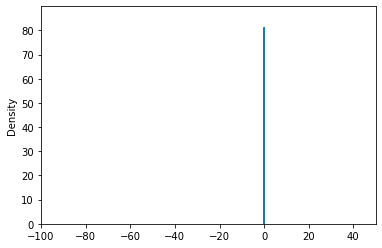

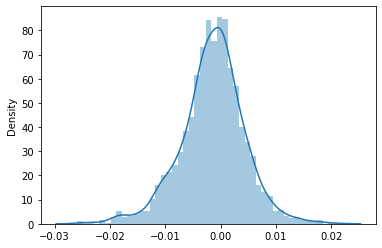

In [75]:
import seaborn as sns
avg_bit_weights = [bit_to_weights[b][1] for b in bit_to_weights.keys()]
print(f'Lowest average bit weight: {min(avg_bit_weights)}')
print(f'Highest average bit weight: {max(avg_bit_weights)}')
print(len(avg_bit_weights))
sns.distplot(avg_bit_weights)
plt.xlim(xmin=-100,xmax=50)
plt.show()

sns.distplot(avg_bit_weights)
plt.show()

In [76]:
# histogram of average bit weights (only including bits set by at least one molecule)
def make_hist_avg_bit_weights(zoomIn=False):
    fig = plt.figure(figsize=(3.5, 1.6), dpi=300)
    if zoomIn:
        bins = np.arange(-0.08, 0.035, 0.003)
    else:
        bins = np.arange(-0.08, 0.035, 0.006)
    _, bins, patches = plt.hist(
        np.clip(avg_bit_weights, -0.08, bins[-1]), 
        bins=bins,  
        density=False,
        zorder=2
    )
    fig.canvas.draw()
    ax = plt.gca()
    if zoomIn:
        ax.set_ylim([0, 20])
    ax.grid(zorder=1)
    ax.set_xlabel('average weight')
    ax.set_ylabel('number of bits')
    plt.tight_layout()
    if zoomIn:
        plt.savefig(pathify(f'bit_weight_histogram_zoomed_in_DD1S_CAIX_FP-FFNN_random_seed_0.png'))
    else:
        plt.savefig(pathify(f'bit_weight_histogram_DD1S_CAIX_FP-FFNN_random_seed_0.png'))
    plt.show()

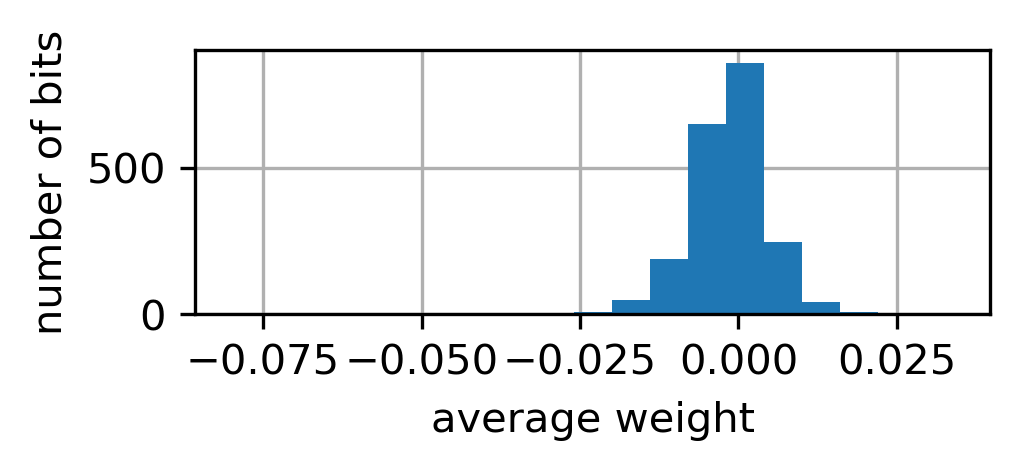

In [77]:
make_hist_avg_bit_weights()

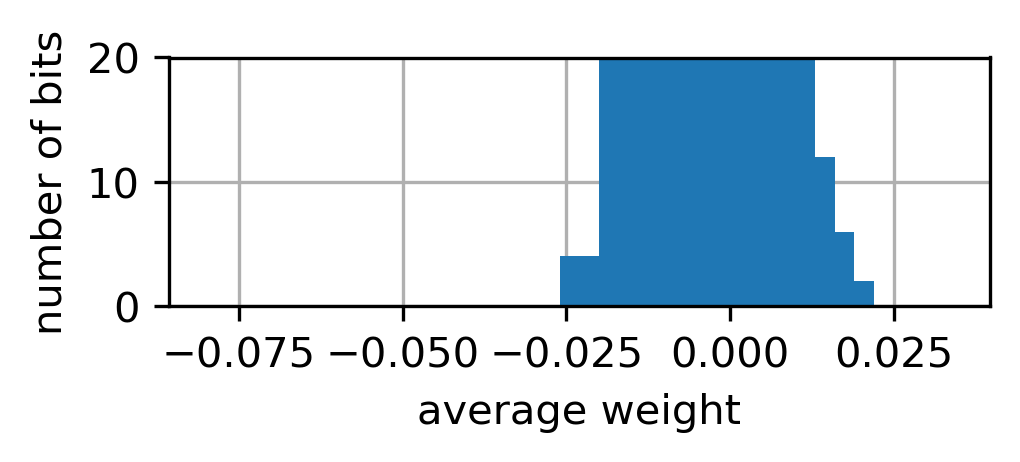

In [78]:
make_hist_avg_bit_weights(zoomIn=True)

### Get bits of interest (based on average bit weight)

In [79]:
bits_sorted_by_avg_weight = sorted(set_bit_ids, key = lambda b: bit_to_weights[b][1])
top_bits = bits_sorted_by_avg_weight[-5:]
top_bits.reverse()
bottom_bits = bits_sorted_by_avg_weight[:3]
bottom_bits.reverse()
print(f'Top bits: {top_bits}')
print(f'Bottom bits: {bottom_bits}')

Top bits: [1561, 1690, 1024, 2023, 1713]
Bottom bits: [1827, 1300, 273]


In [80]:
bits_of_interest = top_bits + bottom_bits
for b in bits_of_interest:
    print(f'Bit ID: {b}')
    print(f'Average weight: {bit_to_weights[b][1]}')
    print(f'Number of molecules with the bit: {len(np.squeeze(np.where(x[:,b]==1)))}')
    print()

Bit ID: 1561
Average weight: 0.021495368393206687
Number of molecules with the bit: 787

Bit ID: 1690
Average weight: 0.019527141500145673
Number of molecules with the bit: 2259

Bit ID: 1024
Average weight: 0.018407179026354237
Number of molecules with the bit: 2194

Bit ID: 2023
Average weight: 0.01798387846094556
Number of molecules with the bit: 400

Bit ID: 1713
Average weight: 0.017940262162823316
Number of molecules with the bit: 1048

Bit ID: 1827
Average weight: -0.024097755345881825
Number of molecules with the bit: 2339

Bit ID: 1300
Average weight: -0.02500458444841065
Number of molecules with the bit: 1318

Bit ID: 273
Average weight: -0.02593414149117432
Number of molecules with the bit: 395



{1561: [18, 500, 798, 1481, 1863, 2846, 2857, 2992, 3171, 3341, 4417, 4458, 4988, 5228, 6446, 6598, 7217, 7904, 8173, 8816, 9269, 9401, 9643, 10389, 12110, 12528, 13069, 13457, 13810, 13943, 14356, 14531, 14619, 14686, 14931, 15087, 15183, 15880, 15948, 16216, 16500, 17322, 17465, 18184, 18602, 19430, 19789, 19794, 19891, 19969, 19994, 20327, 20337, 20402, 20485, 20654, 20962, 21604, 22211, 22473, 22813, 22997, 23168, 23462, 23740, 23969, 24311, 24354, 24490, 25248, 25338, 25982, 26149, 26855, 27005, 27364, 27542, 28335, 28796, 29385, 29700, 29739, 30319, 30399, 30558, 30863, 31280, 31570, 31985, 32094, 32751, 32847, 33065, 33626, 33655, 35056, 35200, 35204, 35597, 35646, 35820, 36325, 37208, 37250, 37451, 38101, 38175, 38237, 38256, 38277, 38317, 38369, 38400, 38432, 38456, 39857, 40208, 40879, 40947, 40965, 41057, 41113, 41186, 41211, 41461, 41472, 41478, 41518, 42237, 42589, 42854, 44013, 44658, 44710, 45066, 45695, 45699, 45714, 45748, 45778, 45795, 45797, 45877, 45922, 46886, 4703

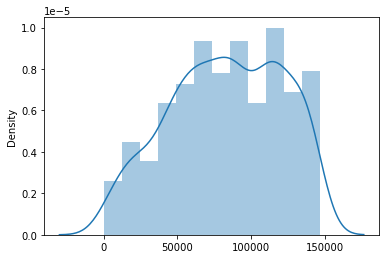

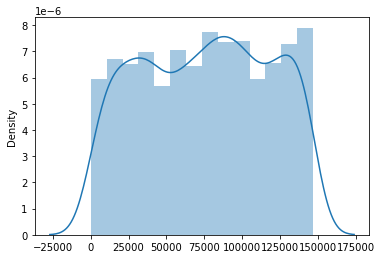

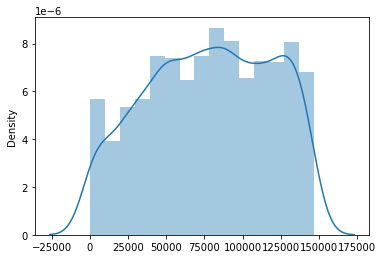

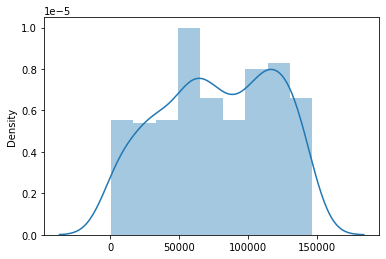

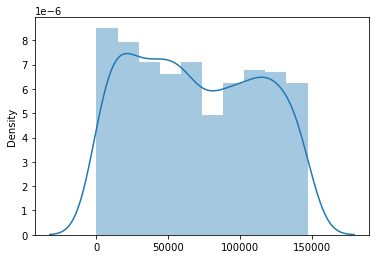

In [81]:
bit_to_cpd_row_indices = {bit: list([idx for idx in np.squeeze(np.where(x[:,bit]==1))]) for bit in bits_of_interest}
print(bit_to_cpd_row_indices)
for item in bit_to_cpd_row_indices.items():
    print(f'Bit ID: {item[0]}')
    print(f'Number of molecules with the bit: {len(item[1])}')
    print()
sns.distplot(bit_to_cpd_row_indices[1561])
plt.show()
sns.distplot(bit_to_cpd_row_indices[1690])
plt.show()
sns.distplot(bit_to_cpd_row_indices[1024],norm_hist=False)
plt.show()

sns.distplot(bit_to_cpd_row_indices[2023],norm_hist=False)
plt.show()

sns.distplot(bit_to_cpd_row_indices[1713],norm_hist=False)
plt.show()

### Plot distributions of molecule-level weights

In [82]:
# histogram of molecule-level bit weights
def make_hist_mol_level_bit_weights(bit_id, x_lb, x_ub, stepsize_noZoom, stepsize_zoom, zoomIn=False):
    weights = bit_to_weights[bit_id][0]
    fig = plt.figure(figsize=(3.5, 1.6), dpi=300)
    if zoomIn:
        bins = np.arange(x_lb, x_ub, stepsize_zoom)
    else:
        bins = np.arange(x_lb, x_ub, stepsize_noZoom) 
    _, bins, patches = plt.hist(
        np.clip(weights, x_lb, bins[-1]), 
        bins=bins,  
        density=False,
        zorder=2
    )
    fig.canvas.draw()
    ax = plt.gca()
    if zoomIn:
        ax.set_ylim([0, 8])
    ax.grid(zorder=1)
    ax.tick_params(labelsize=8)
    ax.set_xlabel('weight', fontsize=8)
    ax.set_ylabel('number of molecules', fontsize=8)
    ax.set_title(f'bit {bit_id}', fontsize=8)
    plt.tight_layout()
    if zoomIn:
        plt.savefig(pathify(f'mol-level_bit_weight_histogram_bit_{bit_id}_zoomed_in_DD1S_CAIX_FP-FFNN_random_seed_0.png'))
    else:
        plt.savefig(pathify(f'mol-level_bit_weight_histogram_bit_{bit_id}_DD1S_CAIX_FP-FFNN_random_seed_0.png'))
    plt.show()

Bit 1561
Lowest molecule-level bit weight: 0.0033854953944683075
Highest molecule-level bit weight: 0.09401841461658478
Mean molecule-level bit weight: 0.021495368393206687
(array([0.02317659, 0.01406182, 0.01178333, 0.01715444, 0.01782086,
       0.02022601, 0.00611588, 0.01695363, 0.01639977, 0.02181129,
       0.01849911, 0.01518437, 0.01973852, 0.01062044, 0.00917642,
       0.01353952, 0.01134461, 0.00973158, 0.01382261, 0.02133296,
       0.01553125, 0.01137573, 0.01162362, 0.01933904, 0.01737319,
       0.01421959, 0.00964691, 0.01502758, 0.02067081, 0.01394607,
       0.01743669, 0.00432532, 0.00969369, 0.01632395, 0.03418676,
       0.02136798, 0.01332848, 0.02160197, 0.02762853, 0.02951591,
       0.02354545, 0.01949382, 0.02693871, 0.01539362, 0.026752  ,
       0.01152322, 0.05038554, 0.01226054, 0.00788986, 0.02148381,
       0.0318403 , 0.00954458, 0.01168249, 0.01831702, 0.01879282,
       0.01176977, 0.03895744, 0.04035968, 0.02459034, 0.01506908,
       0.00684163, 0.0

<AxesSubplot:ylabel='Density'>

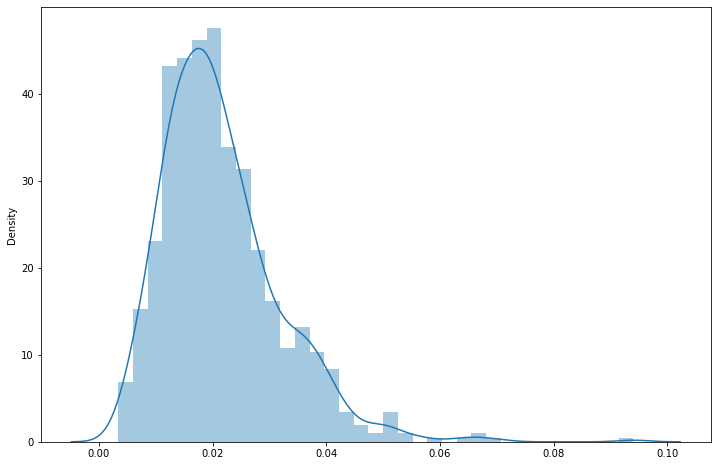

In [83]:
import seaborn as sns
bit = 1561
print(f'Bit {bit}')
print(f'Lowest molecule-level bit weight: {min(bit_to_weights[bit][0])}')
print(f'Highest molecule-level bit weight: {max(bit_to_weights[bit][0])}')
print(f'Mean molecule-level bit weight: {np.mean(bit_to_weights[bit][0])}')
print(bit_to_weights[bit])
print(len(bit_to_weights[bit][0]))
# make_hist_mol_level_bit_weights(bit, -0.02, 0.62, 0.01, None)
plt.figure(figsize=(12,8))
sns.distplot(bit_to_weights[bit][0])

Bit {bit}
Lowest molecule-level bit weight: 0.0038545806892216206
Highest molecule-level bit weight: 0.10521663725376129


<AxesSubplot:ylabel='Density'>

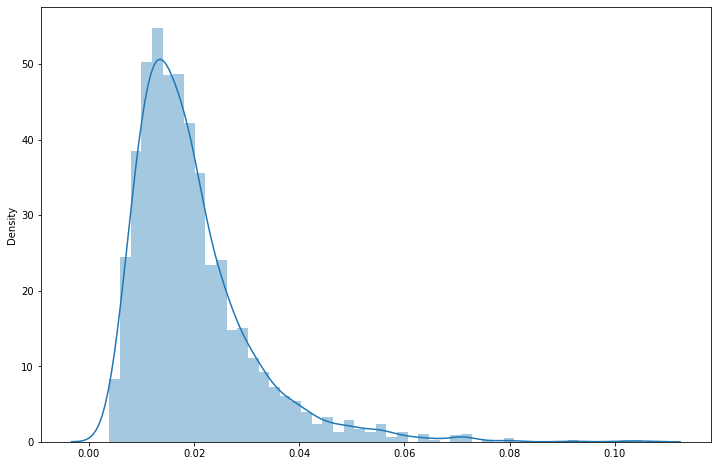

In [84]:
bit = 1690
print('Bit {bit}')
print(f'Lowest molecule-level bit weight: {min(bit_to_weights[bit][0])}')
print(f'Highest molecule-level bit weight: {max(bit_to_weights[bit][0])}')

plt.figure(figsize=(12,8))
sns.distplot(bit_to_weights[bit][0])

Bit {bit}
Lowest molecule-level bit weight: 0.0028736176900565624
Highest molecule-level bit weight: 0.11109772324562073


<AxesSubplot:ylabel='Density'>

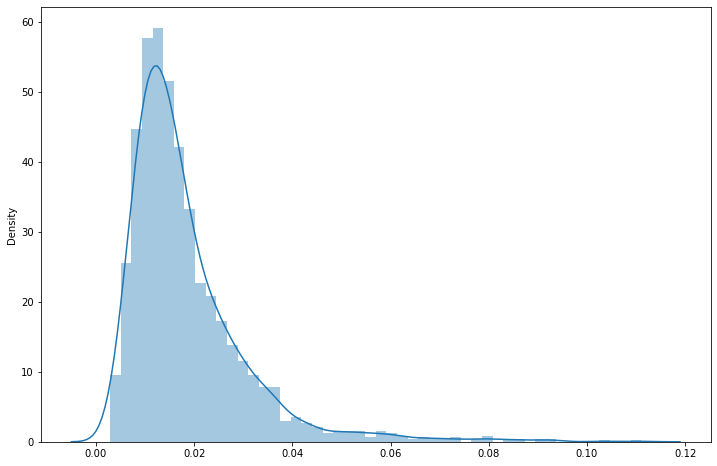

In [85]:
bit = 1024
print('Bit {bit}')
print(f'Lowest molecule-level bit weight: {min(bit_to_weights[bit][0])}')
print(f'Highest molecule-level bit weight: {max(bit_to_weights[bit][0])}')

plt.figure(figsize=(12,8))
sns.distplot(bit_to_weights[bit][0])

Bit 2023
Lowest molecule-level bit weight: 0.003319482784718275
Highest molecule-level bit weight: 0.06957791745662689


<AxesSubplot:ylabel='Density'>

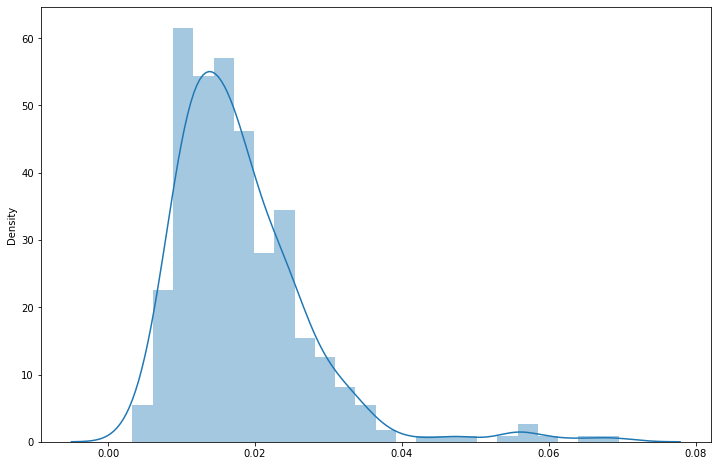

In [86]:
bit = 2023
print(f'Bit {bit}')
print(f'Lowest molecule-level bit weight: {min(bit_to_weights[bit][0])}')
print(f'Highest molecule-level bit weight: {max(bit_to_weights[bit][0])}')

plt.figure(figsize=(12,8))
sns.distplot(bit_to_weights[bit][0])

Bit 153
Lowest molecule-level bit weight: 0.0014144335873425007
Highest molecule-level bit weight: 0.11343061923980713


<AxesSubplot:ylabel='Density'>

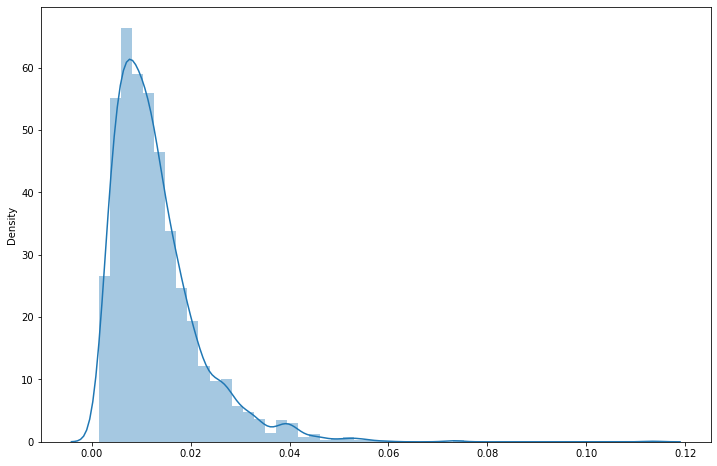

In [87]:
bit = 153
print(f'Bit {bit}')
print(f'Lowest molecule-level bit weight: {min(bit_to_weights[bit][0])}')
print(f'Highest molecule-level bit weight: {max(bit_to_weights[bit][0])}')

plt.figure(figsize=(12,8))
sns.distplot(bit_to_weights[bit][0])

Bit 1713
Lowest molecule-level bit weight: 0.0032305321656167507
Highest molecule-level bit weight: 0.10280507802963257


<AxesSubplot:ylabel='Density'>

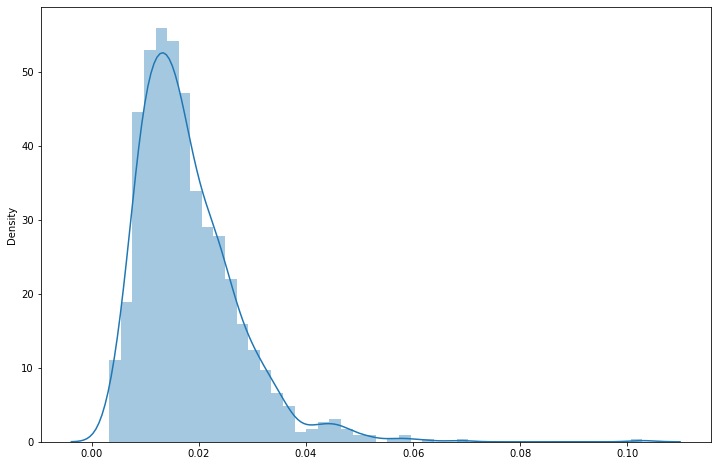

In [88]:
bit = 1713
print(f'Bit {bit}')
print(f'Lowest molecule-level bit weight: {min(bit_to_weights[bit][0])}')
print(f'Highest molecule-level bit weight: {max(bit_to_weights[bit][0])}')

plt.figure(figsize=(12,8))
sns.distplot(bit_to_weights[bit][0])

Bit 379
Lowest molecule-level bit weight: -0.031314969062805176
Highest molecule-level bit weight: -0.0006189788691699505
Mean molecule-level bit weight: -0.0051396670599191405


<AxesSubplot:ylabel='Density'>

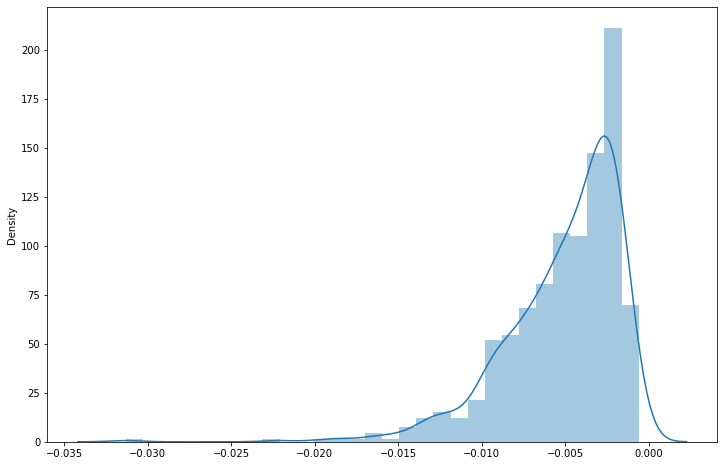

In [89]:
bit = 379
print(f'Bit {bit}')
print(f'Lowest molecule-level bit weight: {min(bit_to_weights[bit][0])}')
print(f'Highest molecule-level bit weight: {max(bit_to_weights[bit][0])}')
print(f'Mean molecule-level bit weight: {np.mean(bit_to_weights[bit][0])}')
plt.figure(figsize=(12,8))
sns.distplot(bit_to_weights[bit][0])

Bit 1516
Lowest molecule-level bit weight: -0.03632888197898865
Highest molecule-level bit weight: -0.0005309130065143108


<AxesSubplot:ylabel='Density'>

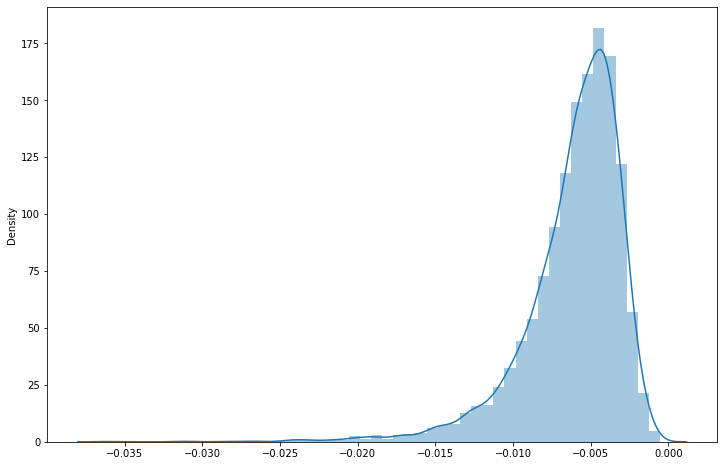

In [90]:
bit = 1516
print(f'Bit {bit}')
print(f'Lowest molecule-level bit weight: {min(bit_to_weights[bit][0])}')
print(f'Highest molecule-level bit weight: {max(bit_to_weights[bit][0])}')

plt.figure(figsize=(12,8))
sns.distplot(bit_to_weights[bit][0])

Bit 762
Lowest molecule-level bit weight: 0.00016704201698303223
Highest molecule-level bit weight: 0.02600497007369995


<AxesSubplot:ylabel='Density'>

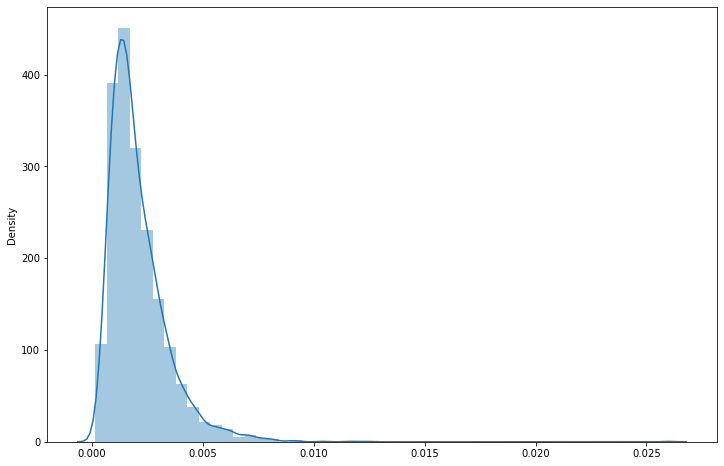

In [91]:
bit = 762
print(f'Bit {bit}')
print(f'Lowest molecule-level bit weight: {min(bit_to_weights[bit][0])}')
print(f'Highest molecule-level bit weight: {max(bit_to_weights[bit][0])}')

plt.figure(figsize=(12,8))
sns.distplot(bit_to_weights[bit][0])

### Get and visualize substructures

In [92]:
bits_to_draw = []
submol_freq_distrib = {bit: {} for bit in bits_of_interest} # store frequency distribution of substructures that 
                                                            # set each bit
smarts_to_smis = {}
submol_to_cpd_indices = {} # mapping to indices in df_data_hasbit
submol_to_bit = {}
examples_all = {bit: {} for bit in bits_of_interest} # check if there's more than one distinct bit-setting 
                                                     # substructure in the same molecule

for bit in tqdm(bits_of_interest):
    df_data_hasbit = df_data.iloc[bit_to_cpd_row_indices[bit]]
    smis = df_data_hasbit['smile']
    print('smis len:',len(smis))
    featurizer = fingerprint.FingerprintFeaturizer(fp_size=2048,radius=3)
    _, info_all = featurizer.prepare_x(df_data_hasbit, bitInfo=True)
    for i, smi in enumerate(smis):
        mol = Chem.MolFromSmiles(smi)
        atomSymbols = getMorganFingerprintAtomSymbols(mol)
        cpd_id = df_data[df_data['smile']==smi].index.to_list()
        # print(cpd_id)
        if bit not in info_all[i]:
            continue
        fragment_logs = getFragmentForMolBit(smi, mol, i, atomSymbols, cpd_id, bit, info_all, submol_freq_distrib,
                        smarts_to_smis, submol_to_cpd_indices, submol_to_bit, bits_to_draw)
        submol_freq_distrib = fragment_logs[0]
        smarts_to_smis = fragment_logs[1]
        submol_to_cpd_indices = fragment_logs[2]
        submol_to_bit = fragment_logs[3]
        bits_to_draw = fragment_logs[4]
        examples = fragment_logs[5]
        if examples:
            examples_all[bit][i] = examples
print(len(submol_freq_distrib),len(smarts_to_smis),len(submol_to_cpd_indices),len(submol_to_bit),len(bits_to_draw),len(examples))

  0%|          | 0/8 [00:00<?, ?it/s]

smis len: 787



100%|██████████| 787/787 [00:01<00:00, 479.29it/s]


cpd_id: [144]
SMILES string: O=C(COc1ccc(Br)cc1)N[C@@H](Cc1cccc2ccccc12)C(=O)N[C@H](CCc1ccccc1)C(=O)O
bit ID: 1561
(atom, radius): (16, 3)
molecular fragment (SMILES): c1:c:c(-C):c:c(:c):c:1
molecular fragment (SMARTS): [#6;D2;H1;R1;+0]:[#6;D3;H0;R2;+0]1:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D3;H0;R1;+0](-[#6;D2;H2;R0;+0]):[#6;D3;H0;R2;+0]:1

cpd_id: [39904]
SMILES string: O=C(CC[C@H](NC(=O)c1cc2cc(Br)ccc2c(Br)c1O)C(=O)N[C@H](CCc1ccccc1)C(=O)O)NC(c1ccccc1)(c1ccccc1)c1ccccc1
bit ID: 1561
(atom, radius): (15, 3)
molecular fragment (SMILES): c1:c:c(-Br):c:c(:c):c:1:c(:c)-Br
molecular fragment (SMARTS): [#35;D1;H0;R0;+0]-[#6;D3;H0;R1;+0]1:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D3;H0;R2;+0](:[#6;D3;H0;R1;+0](-[#35;D1;H0;R0;+0]):[#6;D3;H0;R1;+0]):[#6;D3;H0;R2;+0](:[#6;D2;H1;R1;+0]):[#6;D2;H1;R1;+0]:1

cpd_id: [159952]
SMILES string: C[C@H](O)[C@@H](NC(=O)c1sccc1Cl)C(=O)N[C@@H](CC(=O)O)C(=O)OC(C)(C)C
bit ID: 1561
(atom, radius): (5, 3)
molecular fragment (SMILES): C(=O)(-N-[C@

 12%|█▎        | 1/8 [00:21<02:27, 21.08s/it]

smis len: 2259



100%|██████████| 2259/2259 [00:04<00:00, 470.99it/s]


cpd_id: [1232]
SMILES string: COc1ccc(C(NC(=O)C[C@H](CSc2ccccc2)NC(=O)c2ccnc(Cl)n2)c2ccc(OCC(=O)O)cc2)c(OC)c1
bit ID: 1690
(atom, radius): (7, 2)
molecular fragment (SMILES): N(-C(-C)=O)-C(-c)-c
molecular fragment (SMARTS): [#6;D2;H2;R0;+0]-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#7;D2;H1;R0;+0]-[#6;D3;H1;R0;+0](-[#6;D3;H0;R1;+0])-[#6;D3;H0;R1;+0]

cpd_id: [2264]
SMILES string: Cc1ccc(C[C@H](NC(=O)Cc2ccccn2)C(=O)NC(CC2CCCN(C(=O)OC(C)(C)C)C2)C(=O)O)cc1
bit ID: 1690
(atom, radius): (19, 3)
molecular fragment (SMILES): N(-C(=O)-[C@H](-C)-N)-C(-C-C)-C(=O)-O
molecular fragment (SMARTS): [#6;D2;H2;R0;+0]-[#6;D3;H1;R0;+0](-[#7;D2;H1;R0;+0])-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#7;D2;H1;R0;+0]-[#6;D3;H1;R0;+0](-[#6;D2;H2;R0;+0]-[#6;D3;H1;R1;+0])-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#8;D1;H1;R0;+0]

cpd_id: [2696]
SMILES string: O=C(Cc1ccc(Oc2ccccc2)cc1)N[C@@H]1CCC[C@H]1C(=O)N[C@@H]1CCC[C@H]1C(=O)O
bit ID: 1690
(atom, radius): (4, 3)
molecular fragment (SMILES): c1:c:c(-O):c:c:c:1-C-C
molecular fr

 25%|██▌       | 2/8 [01:21<04:25, 44.33s/it]

smis len: 2194



100%|██████████| 2194/2194 [00:07<00:00, 310.67it/s]


cpd_id: [200]
SMILES string: CC(C)(C)SSC[C@H](NC(=O)c1cccc(F)c1Br)C(=O)N[C@H](CCc1ccccc1)C(=O)O
bit ID: 1024
(atom, radius): (5, 1)
molecular fragment (SMILES): S(-C)-S
molecular fragment (SMARTS): [#16;D2;H0;R0;+0]-[#16;D2;H0;R0;+0]-[#6;D2;H2;R0;+0]

cpd_id: [528]
SMILES string: CSCCC(NC(C)=O)C(=O)N[C@@H](Cc1cnc[nH]1)C(=O)N[C@@H](CC(=O)NC(c1ccccc1)(c1ccccc1)c1ccccc1)C(=O)O
bit ID: 1024
(atom, radius): (3, 2)
molecular fragment (SMILES): C(-C-S)-C(-C)-N
molecular fragment (SMARTS): [#16;D2;H0;R0;+0]-[#6;D2;H2;R0;+0]-[#6;D2;H2;R0;+0]-[#6;D3;H1;R0;+0](-[#6;D3;H0;R0;+0])-[#7;D2;H1;R0;+0]

cpd_id: [1072]
SMILES string: CC(C)(C)OC(=O)N[C@@H](CCCCNC(=O)[C@H](C/C=C/c1ccccc1)NC(=O)[C@@H]1CCCCN1C(=O)OC(C)(C)C)C(=O)O
bit ID: 1024
(atom, radius): (22, 3)
molecular fragment (SMILES): c1:c:c:c:c(-C):c:1
molecular fragment (SMARTS): [#6;D2;H1;R0;+0]-[#6;D3;H0;R1;+0]1:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:1

cpd_id: [1216]
SMILES string: C[C@@](O)(C(=O)N

 38%|███▊      | 3/8 [02:23<04:21, 52.40s/it]

smis len: 400



100%|██████████| 400/400 [00:00<00:00, 491.63it/s]


cpd_id: [3472]
SMILES string: C[C@@H](O)[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)/C=C/c1cccc(F)c1)C(=O)O
bit ID: 2023
(atom, radius): (21, 3)
molecular fragment (SMILES): c1(-F):c:c:c:c(-C):c:1
molecular fragment (SMARTS): [#6;D2;H1;R0;+0]-[#6;D3;H0;R1;+0]1:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D3;H0;R1;+0](-[#9;D1;H0;R0;+0]):[#6;D2;H1;R1;+0]:1

cpd_id: [18504]
SMILES string: O=C(N[C@@H](Cc1cccs1)C(=O)N1CCCC(C(=O)O)C1)c1cc(F)c(Cl)cc1Cl
bit ID: 2023
(atom, radius): (3, 3)
molecular fragment (SMILES): [C@@H](-C-c(:c):s)(-N-C(-c)=O)-C(=O)-N(-C)-C
molecular fragment (SMARTS): [#16;D2;H0;R1;+0]:[#6;D3;H0;R1;+0](:[#6;D2;H1;R1;+0])-[#6;D2;H2;R0;+0]-[#6;D3;H1;R0;+0](-[#7;D2;H1;R0;+0]-[#6;D3;H0;R0;+0](-[#6;D3;H0;R1;+0])=[#8;D1;H0;R0;+0])-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#7;D3;H0;R1;+0](-[#6;D2;H2;R1;+0])-[#6;D2;H2;R1;+0]

cpd_id: [20208]
SMILES string: CC[C@H](C)[C@@H](NC(=O)c1cc2cc(Br)ccc2[nH]1)C(=O)N1CSC[C@H]1C(=O)O
bit ID: 2023
(atom, radius): (18, 3)
molecular fragment (SMILES):

 50%|█████     | 4/8 [02:34<02:23, 35.96s/it]

smis len: 1048



100%|██████████| 1048/1048 [00:02<00:00, 489.81it/s]


cpd_id: [464]
SMILES string: O=C(O)C[C@@H](Cc1ccc(I)cc1)NC(=O)[C@@H](CCC(=O)NC(c1ccccc1)(c1ccccc1)c1ccccc1)NC(=O)c1cc(F)c(Cl)cc1Cl
bit ID: 1713
(atom, radius): (42, 3)
molecular fragment (SMILES): C(=O)(-N-[C@@H](-C)-C)-c(:c:c):c(:c)-Cl
molecular fragment (SMARTS): [#17;D1;H0;R0;+0]-[#6;D3;H0;R1;+0](:[#6;D2;H1;R1;+0]):[#6;D3;H0;R1;+0](:[#6;D2;H1;R1;+0]:[#6;D3;H0;R1;+0])-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#7;D2;H1;R0;+0]-[#6;D3;H1;R0;+0](-[#6;D2;H2;R0;+0])-[#6;D3;H0;R0;+0]

cpd_id: [3920]
SMILES string: COc1ccc(CN(CC(=O)N[C@H](CCc2ccccc2)C(=O)O)C(=O)/C=C/c2cccc(Cl)c2)c(O)c1
bit ID: 1713
(atom, radius): (30, 3)
molecular fragment (SMILES): c1:c:c(-C):c:c(-Cl):c:1
molecular fragment (SMARTS): [#17;D1;H0;R0;+0]-[#6;D3;H0;R1;+0]1:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D3;H0;R1;+0](-[#6;D2;H1;R0;+0]):[#6;D2;H1;R1;+0]:1

cpd_id: [6528]
SMILES string: CC(C)(C)OC(=O)N[C@H](CNC(=O)CCCC(=O)c1ccccc1)C(=O)N[C@H](Cc1ccc(C(=O)c2ccccc2)cc1)C(=O)O
bit ID: 1713
(atom, radius): (10, 3)


 62%|██████▎   | 5/8 [03:02<01:39, 33.19s/it]

smis len: 2339



100%|██████████| 2339/2339 [00:05<00:00, 464.44it/s]


cpd_id: [440]
SMILES string: COc1cc(C)c(S(=O)(=O)NC(N)=NCCC[C@@H](NC(=O)Cc2cc(C)nn2C)C(=O)N[C@H](CCc2ccccc2)C(=O)O)c(C)c1C
bit ID: 1827
(atom, radius): (26, 2)
molecular fragment (SMILES): n(:c(:c)-C):n(:c)-C
molecular fragment (SMARTS): [#6;D1;H3;R0;+0]-[#6;D3;H0;R1;+0](:[#6;D2;H1;R1;+0]):[#7;D2;H0;R1;+0]:[#7;D3;H0;R1;+0](-[#6;D1;H3;R0;+0]):[#6;D3;H0;R1;+0]

cpd_id: [544]
SMILES string: COc1ccc(C(NC(=O)[C@H](Cc2cccc(C)c2)NC(=O)c2ccc(=O)oc2)c2ccc(OCC(=O)O)cc2)c(OC)c1
bit ID: 1827
(atom, radius): (25, 1)
molecular fragment (SMILES): c(:c)(=O):o
molecular fragment (SMARTS): [#6;D2;H1;R1;+0]:[#6;D3;H0;R1;+0](=[#8;D1;H0;R0;+0]):[#8;D2;H0;R1;+0]

cpd_id: [1776]
SMILES string: CC(=O)N[C@@H]1[C@@H](O)C[C@@](O)(C(=O)N[C@@H](CCCN=C(NC(=O)OC(C)(C)C)NC(=O)OC(C)(C)C)C(=O)NCCCC[C@H](NC(=O)OC(C)(C)C)C(=O)O)O[C@H]1[C@H](O)[C@H](O)CO
bit ID: 1827
(atom, radius): (19, 3)
molecular fragment (SMILES): N(-C(=O)-O-C)-C(=N-C)-N-C
molecular fragment (SMARTS): [#6;D2;H2;R0;+0]-[#7;D2;H0;R0;+0]=[#6;D3;H0;R0;+0

 75%|███████▌  | 6/8 [04:06<01:27, 43.61s/it]

smis len: 1318



100%|██████████| 1318/1318 [00:02<00:00, 492.43it/s]


cpd_id: [808]
SMILES string: CC(=O)N1CCC[C@H]1C(=O)N1C[C@@H](F)C[C@H]1C(=O)N[C@H](CCc1ccccc1)C(=O)O
bit ID: 1300
(atom, radius): (1, 1)
molecular fragment (SMILES): C(-C)(-N)=O
molecular fragment (SMARTS): [#6;D1;H3;R0;+0]-[#6;D3;H0;R0;+0](-[#7;D3;H0;R1;+0])=[#8;D1;H0;R0;+0]

cpd_id: [1112]
SMILES string: Cc1ccc(C(F)(F)F)cc1C(=O)N[C@H](Cc1cccs1)C(=O)N[C@H](Cc1ccncc1)C(=O)O
bit ID: 1300
(atom, radius): (9, 2)
molecular fragment (SMILES): c(:c(-C):c):c(:c)-C
molecular fragment (SMARTS): [#6;D2;H1;R1;+0]:[#6;D3;H0;R1;+0](-[#6;D4;H0;R0;+0]):[#6;D2;H1;R1;+0]:[#6;D3;H0;R1;+0](-[#6;D3;H0;R0;+0]):[#6;D3;H0;R1;+0]

cpd_id: [1984]
SMILES string: CC(=O)CCCC(=O)N[C@H](CC(=O)NC(c1ccccc1)(c1ccccc1)c1ccccc1)C(=O)N[C@H](C(=O)O)C(C)C
bit ID: 1300
(atom, radius): (33, 3)
molecular fragment (SMILES): C(=O)(-N-[C@H](-C)-C)-[C@@H](-C-C)-N-C
molecular fragment (SMARTS): [#6;D3;H0;R0;+0]-[#6;D2;H2;R0;+0]-[#6;D3;H1;R0;+0](-[#7;D2;H1;R0;+0]-[#6;D3;H0;R0;+0])-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#7;D2;H1;R0;+0]

 88%|████████▊ | 7/8 [04:41<00:40, 40.78s/it]

smis len: 395



100%|██████████| 395/395 [00:00<00:00, 500.21it/s]


cpd_id: [10432]
SMILES string: C#CC[C@@H](NC(=O)C[C@H]1CCCN1C(=O)c1cccc(OC)c1)C(=O)O
bit ID: 273
(atom, radius): (18, 3)
molecular fragment (SMILES): c1:c:c:c:c:c:1-O-C
molecular fragment (SMARTS): [#6;D1;H3;R0;+0]-[#8;D2;H0;R0;+0]-[#6;D3;H0;R1;+0]1:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D3;H0;R1;+0]:[#6;D2;H1;R1;+0]:1

cpd_id: [16440]
SMILES string: CSCC[C@H](NC(C)=O)C(=O)N1CC=C[C@H]1C(=O)N[C@H](Cc1ccc(C(=O)c2ccccc2)cc1)C(=O)O
bit ID: 273
(atom, radius): (3, 3)
molecular fragment (SMILES): C(-C-S-C)-[C@H](-N-C)-C(-N)=O
molecular fragment (SMARTS): [#6;D1;H3;R0;+0]-[#16;D2;H0;R0;+0]-[#6;D2;H2;R0;+0]-[#6;D2;H2;R0;+0]-[#6;D3;H1;R0;+0](-[#7;D2;H1;R0;+0]-[#6;D3;H0;R0;+0])-[#6;D3;H0;R0;+0](-[#7;D3;H0;R1;+0])=[#8;D1;H0;R0;+0]

cpd_id: [70624]
SMILES string: Cc1ocnc1C(=O)N[C@@H](COC(C)(C)C)C(=O)N[C@@H](CCCN=C(N)NS(=O)(=O)c1c(C)c(C)c2c(c1C)CC(C)(C)O2)C(=O)O
bit ID: 273
(atom, radius): (8, 3)
molecular fragment (SMILES): N(-C(=O)-c(:c):n)-[C@@H](-C-O)-C(-N)=O
molecular fragment 

100%|██████████| 8/8 [04:51<00:00, 36.49s/it]

8 112 112 112 112 0


In [95]:
hkl.dump(submol_freq_distrib, 'submol_freq_distrib.hkl', mode='w')
hkl.dump(smarts_to_smis, 'smarts_to_smis.hkl', mode='w')
hkl.dump(submol_to_cpd_indices, 'submol_to_cpd_indices.hkl', mode='w')
hkl.dump(submol_to_bit, 'submol_to_bit.hkl', mode='w')
hkl.dump(bits_to_draw, 'bits_to_draw.hkl', mode='w')
hkl.dump(examples_all, 'examples_all.hkl', mode='w')

In [96]:
# submol_freq_distrib_hkl = hkl.load('submol_freq_distrib.hkl')
# submol_freq_distrib = {int(bit): d for bit, d in submol_freq_distrib_hkl.items()}
# smarts_to_smis = hkl.load('smarts_to_smis.hkl')
# submol_to_cpd_indices = hkl.load('submol_to_cpd_indices.hkl')
# submol_to_bit = hkl.load('submol_to_bit.hkl')
# examples_all_hkl = hkl.load('examples_all.hkl')
# examples_all = {int(bit): {int(mol_idx): [int(ex_num) for ex_num in ex_nums] for mol_idx, ex_nums in exs.items()} for bit, exs in examples_all_hkl.items()}
# bits_to_draw = hkl.load('bits_to_draw.hkl')
# bits_to_draw = [(int(item[0]), Chem.MolFromSmiles(df_data.iloc[int(item[0])-1]['smiles']), int(item[2]),
#         {int(bit): tuple([(int(an[0]), int(an[1])) for an in ans]) for bit, ans in item[3].items()}) for item in bits_to_draw_hkl]

In [98]:
for item in smarts_to_smis.items():
    print(f'SMARTS: {item[0]}')
    print(f'SMILES: {np.squeeze(item[1])}')
    print()
print()
print(f'Number of distinct SMARTS: {len(set(smarts_to_smis.keys()))}')
print(f'Number of distinct SMILES: {len(set([j for i in smarts_to_smis.values() for j in i]))}')

SMARTS: [#6;D2;H1;R1;+0]:[#6;D3;H0;R2;+0]1:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D3;H0;R1;+0](-[#6;D2;H2;R0;+0]):[#6;D3;H0;R2;+0]:1
SMILES: c1:c:c(-C):c:c(:c):c:1

SMARTS: [#35;D1;H0;R0;+0]-[#6;D3;H0;R1;+0]1:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D3;H0;R2;+0](:[#6;D3;H0;R1;+0](-[#35;D1;H0;R0;+0]):[#6;D3;H0;R1;+0]):[#6;D3;H0;R2;+0](:[#6;D2;H1;R1;+0]):[#6;D2;H1;R1;+0]:1
SMILES: c1:c:c(-Br):c:c(:c):c:1:c(:c)-Br

SMARTS: [#17;D1;H0;R0;+0]-[#6;D3;H0;R1;+0](:[#6;D2;H1;R1;+0]):[#6;D3;H0;R1;+0](:[#16;D2;H0;R1;+0]:[#6;D2;H1;R1;+0])-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#7;D2;H1;R0;+0]-[#6;D3;H1;R0;+0](-[#6;D3;H0;R0;+0])-[#6;D3;H1;R0;+0]
SMILES: C(=O)(-N-[C@@H](-C)-C)-c(:s:c):c(:c)-Cl

SMARTS: [#16;D2;H0;R0;+0]-[#6;D2;H2;R0;+0]-[#6;D3;H1;R0;+0](-[#6;D2;H2;R0;+0]-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#7;D3;H0;R1;+0](-[#6;D2;H2;R1;+0])-[#6;D3;H1;R1;+0])-[#7;D2;H1;R0;+0]-[#6;D3;H0;R0;+0]
SMILES: C(-C(=O)-N(-C)-C)-[C@H](-C-S)-N-C

SMARTS: [#6;D1;H3;R0;+0]-[#6;D4;H0;R0;+0](-[#6;D1;H3;R0

In [42]:
submol_freq_distrib

{1561: {'[#6;D2;H1;R1;+0]:[#6;D3;H0;R2;+0]1:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D3;H0;R1;+0](-[#6;D2;H2;R0;+0]):[#6;D3;H0;R2;+0]:1': 579,
  '[#35;D1;H0;R0;+0]-[#6;D3;H0;R1;+0]1:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D3;H0;R2;+0](:[#6;D3;H0;R1;+0](-[#35;D1;H0;R0;+0]):[#6;D3;H0;R1;+0]):[#6;D3;H0;R2;+0](:[#6;D2;H1;R1;+0]):[#6;D2;H1;R1;+0]:1': 147,
  '[#17;D1;H0;R0;+0]-[#6;D3;H0;R1;+0](:[#6;D2;H1;R1;+0]):[#6;D3;H0;R1;+0](:[#16;D2;H0;R1;+0]:[#6;D2;H1;R1;+0])-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#7;D2;H1;R0;+0]-[#6;D3;H1;R0;+0](-[#6;D3;H0;R0;+0])-[#6;D3;H1;R0;+0]': 6,
  '[#16;D2;H0;R0;+0]-[#6;D2;H2;R0;+0]-[#6;D3;H1;R0;+0](-[#6;D2;H2;R0;+0]-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#7;D3;H0;R1;+0](-[#6;D2;H2;R1;+0])-[#6;D3;H1;R1;+0])-[#7;D2;H1;R0;+0]-[#6;D3;H0;R0;+0]': 23,
  '[#6;D1;H3;R0;+0]-[#6;D4;H0;R0;+0](-[#6;D1;H3;R0;+0])(-[#6;D3;H0;R0;+0])-[#7;D2;H1;R0;+0]-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#6;D3;H0;R1;+0](:[#6;D2;H1;R1;+0]:[#6;D3;H0;R1;+0]):[#7;D2;H0;R1;+0]:[#8;D2;H0;R1

In [99]:
bits_to_draw

[([144],
  1561,
  {1: ((12, 0), (27, 0)),
   17: ((14, 3),),
   32: ((32, 3),),
   38: ((23, 3),),
   41: ((1, 1),),
   79: ((13, 1),),
   80: ((2, 0), (13, 0), (28, 0), (29, 0)),
   102: ((4, 2),),
   117: ((11, 1), (26, 1)),
   133: ((3, 3),),
   147: ((12, 1),),
   148: ((27, 1),),
   192: ((2, 2),),
   236: ((12, 2),),
   255: ((5, 3),),
   288: ((2, 3),),
   322: ((4, 1),),
   340: ((11, 3),),
   389: ((38, 1), (33, 2)),
   394: ((27, 2),),
   444: ((27, 3),),
   524: ((19, 3),),
   530: ((28, 2),),
   573: ((24, 1),),
   583: ((29, 3),),
   649: ((23, 2),),
   650: ((0, 0), (25, 0), (37, 0)),
   669: ((13, 2),),
   688: ((1, 2),),
   695: ((3, 0),),
   718: ((5, 2), (10, 2)),
   721: ((1, 3),),
   728: ((8, 0),),
   731: ((17, 3),),
   739: ((28, 1),),
   807: ((1, 0), (24, 0), (36, 0), (38, 0)),
   836: ((18, 3),),
   909: ((7, 1),),
   951: ((20, 3),),
   1039: ((16, 2),),
   1045: ((30, 2),),
   1066: ((31, 2), (35, 2)),
   1073: ((22, 3),),
   1077: ((31, 3),),
   1080: ((4,

In [100]:
for bit in submol_freq_distrib:
    print(f'Bit ID: {bit}')
    for submol in submol_freq_distrib[bit]:
        print(f'Substructure (SMARTS): {submol}')
        print(f'Frequency: {submol_freq_distrib[bit][submol]}')
    print()

Bit ID: 1561
Substructure (SMARTS): [#6;D2;H1;R1;+0]:[#6;D3;H0;R2;+0]1:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D3;H0;R1;+0](-[#6;D2;H2;R0;+0]):[#6;D3;H0;R2;+0]:1
Frequency: 579
Substructure (SMARTS): [#35;D1;H0;R0;+0]-[#6;D3;H0;R1;+0]1:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D3;H0;R2;+0](:[#6;D3;H0;R1;+0](-[#35;D1;H0;R0;+0]):[#6;D3;H0;R1;+0]):[#6;D3;H0;R2;+0](:[#6;D2;H1;R1;+0]):[#6;D2;H1;R1;+0]:1
Frequency: 147
Substructure (SMARTS): [#17;D1;H0;R0;+0]-[#6;D3;H0;R1;+0](:[#6;D2;H1;R1;+0]):[#6;D3;H0;R1;+0](:[#16;D2;H0;R1;+0]:[#6;D2;H1;R1;+0])-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#7;D2;H1;R0;+0]-[#6;D3;H1;R0;+0](-[#6;D3;H0;R0;+0])-[#6;D3;H1;R0;+0]
Frequency: 6
Substructure (SMARTS): [#16;D2;H0;R0;+0]-[#6;D2;H2;R0;+0]-[#6;D3;H1;R0;+0](-[#6;D2;H2;R0;+0]-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#7;D3;H0;R1;+0](-[#6;D2;H2;R1;+0])-[#6;D3;H1;R1;+0])-[#7;D2;H1;R0;+0]-[#6;D3;H0;R0;+0]
Frequency: 23
Substructure (SMARTS): [#6;D1;H3;R0;+0]-[#6;D4;H0;R0;+0](-[#6;D1;H3;R0;+0])(-[#6;D3;H0;R0;+

In [101]:
bits_to_draw

[([144],
  1561,
  {1: ((12, 0), (27, 0)),
   17: ((14, 3),),
   32: ((32, 3),),
   38: ((23, 3),),
   41: ((1, 1),),
   79: ((13, 1),),
   80: ((2, 0), (13, 0), (28, 0), (29, 0)),
   102: ((4, 2),),
   117: ((11, 1), (26, 1)),
   133: ((3, 3),),
   147: ((12, 1),),
   148: ((27, 1),),
   192: ((2, 2),),
   236: ((12, 2),),
   255: ((5, 3),),
   288: ((2, 3),),
   322: ((4, 1),),
   340: ((11, 3),),
   389: ((38, 1), (33, 2)),
   394: ((27, 2),),
   444: ((27, 3),),
   524: ((19, 3),),
   530: ((28, 2),),
   573: ((24, 1),),
   583: ((29, 3),),
   649: ((23, 2),),
   650: ((0, 0), (25, 0), (37, 0)),
   669: ((13, 2),),
   688: ((1, 2),),
   695: ((3, 0),),
   718: ((5, 2), (10, 2)),
   721: ((1, 3),),
   728: ((8, 0),),
   731: ((17, 3),),
   739: ((28, 1),),
   807: ((1, 0), (24, 0), (36, 0), (38, 0)),
   836: ((18, 3),),
   909: ((7, 1),),
   951: ((20, 3),),
   1039: ((16, 2),),
   1045: ((30, 2),),
   1066: ((31, 2), (35, 2)),
   1073: ((22, 3),),
   1077: ((31, 3),),
   1080: ((4,

In [102]:
_bits_to_draw = [bit[1:] for bit in bits_to_draw]
_bits_to_draw

[(<rdkit.Chem.rdchem.Mol at 0x7fb7f4eb4f40>,
  1561,
  {1: ((12, 0), (27, 0)),
   17: ((14, 3),),
   32: ((32, 3),),
   38: ((23, 3),),
   41: ((1, 1),),
   79: ((13, 1),),
   80: ((2, 0), (13, 0), (28, 0), (29, 0)),
   102: ((4, 2),),
   117: ((11, 1), (26, 1)),
   133: ((3, 3),),
   147: ((12, 1),),
   148: ((27, 1),),
   192: ((2, 2),),
   236: ((12, 2),),
   255: ((5, 3),),
   288: ((2, 3),),
   322: ((4, 1),),
   340: ((11, 3),),
   389: ((38, 1), (33, 2)),
   394: ((27, 2),),
   444: ((27, 3),),
   524: ((19, 3),),
   530: ((28, 2),),
   573: ((24, 1),),
   583: ((29, 3),),
   649: ((23, 2),),
   650: ((0, 0), (25, 0), (37, 0)),
   669: ((13, 2),),
   688: ((1, 2),),
   695: ((3, 0),),
   718: ((5, 2), (10, 2)),
   721: ((1, 3),),
   728: ((8, 0),),
   731: ((17, 3),),
   739: ((28, 1),),
   807: ((1, 0), (24, 0), (36, 0), (38, 0)),
   836: ((18, 3),),
   909: ((7, 1),),
   951: ((20, 3),),
   1039: ((16, 2),),
   1045: ((30, 2),),
   1066: ((31, 2), (35, 2)),
   1073: ((22, 3),)

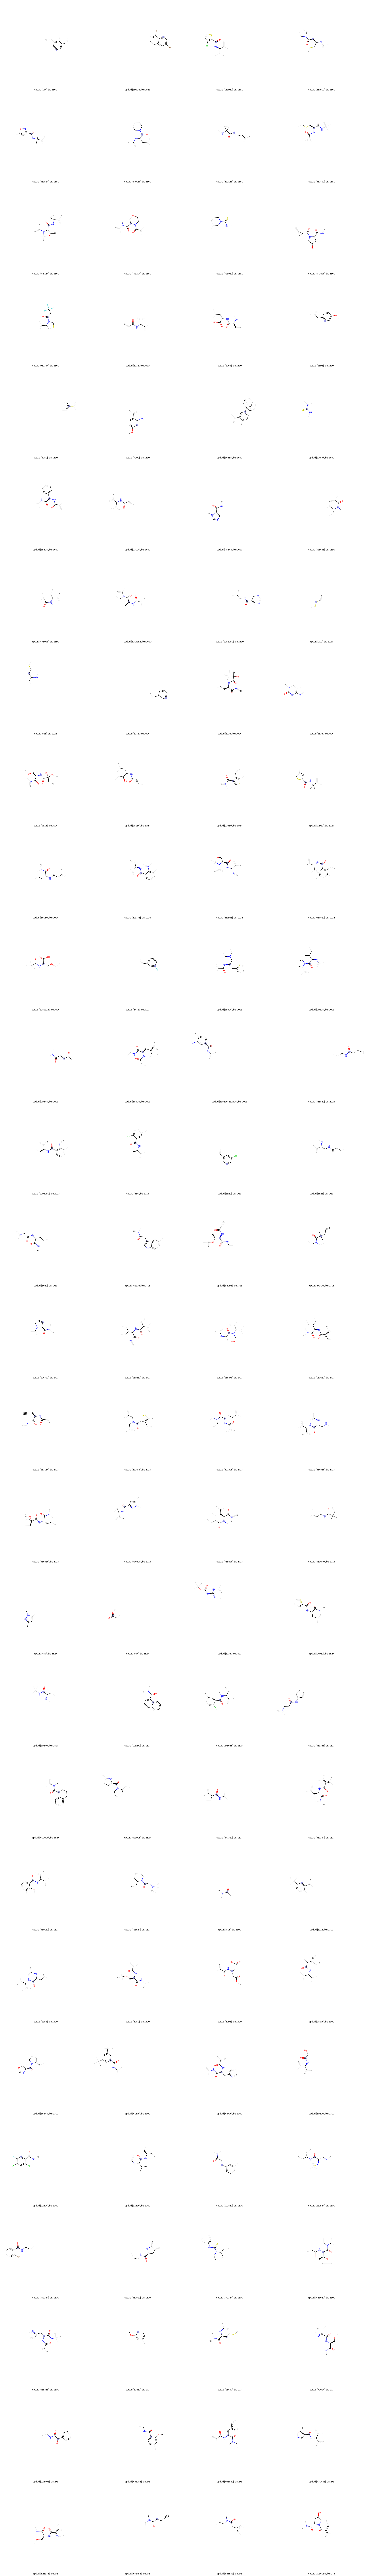

In [103]:
# visualize each substructure
d = Draw.DrawMorganBits(_bits_to_draw, molsPerRow=4,aromaticColor=None,ringColor=None,
                        legends=[f'cpd_id {bit[0]}, bit: {bit[2]}' for bit in bits_to_draw], subImgSize=(600, 600),)
d.save(pathify(f'bits_visualization.png'))
d

## Substructure analysis

### Number substructures

In [104]:
# numbering correponds to ordering of bars from left to right on plot of substructure weights (see below)
ctr = 1
submol_to_id = {}
for bit in bits_of_interest:
    submols = sorted(submol_freq_distrib[bit].keys(), key = lambda x: submol_freq_distrib[bit][x], reverse=True)
    for s in submols:
        submol_to_id[s] = ctr
        ctr += 1

submol_to_id

{'[#6;D2;H1;R1;+0]:[#6;D3;H0;R2;+0]1:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D3;H0;R1;+0](-[#6;D2;H2;R0;+0]):[#6;D3;H0;R2;+0]:1': 1,
 '[#35;D1;H0;R0;+0]-[#6;D3;H0;R1;+0]1:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D3;H0;R2;+0](:[#6;D3;H0;R1;+0](-[#35;D1;H0;R0;+0]):[#6;D3;H0;R1;+0]):[#6;D3;H0;R2;+0](:[#6;D2;H1;R1;+0]):[#6;D2;H1;R1;+0]:1': 2,
 '[#16;D2;H0;R0;+0]-[#6;D2;H2;R0;+0]-[#6;D3;H1;R0;+0](-[#6;D2;H2;R0;+0]-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#7;D3;H0;R1;+0](-[#6;D2;H2;R1;+0])-[#6;D3;H1;R1;+0])-[#7;D2;H1;R0;+0]-[#6;D3;H0;R0;+0]': 3,
 '[#6;D2;H2;R1;+0]-[#6;D2;H2;R1;+0]-[#7;D3;H0;R1;+0](-[#6;D2;H2;R1;+0]-[#6;D2;H2;R1;+0])-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#6;D3;H1;R0;+0](-[#6;D2;H2;R0;+0]-[#6;D3;H0;R1;+0])-[#7;D2;H1;R0;+0]-[#6;D3;H0;R0;+0]': 4,
 '[#17;D1;H0;R0;+0]-[#6;D3;H0;R1;+0](:[#6;D2;H1;R1;+0]):[#6;D3;H0;R1;+0](:[#16;D2;H0;R1;+0]:[#6;D2;H1;R1;+0])-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#7;D2;H1;R0;+0]-[#6;D3;H1;R0;+0](-[#6;D3;H0;R0;+0])-[#6;D3;H1;R0;+0]': 5,
 '[#6;D2

In [105]:
hkl.dump(submol_to_id, 'submol_to_id_DD1S_CAIX_FP-FFNN_random_seed_0.hkl', mode='w')

In [107]:
for item in sorted(submol_to_id.items(), key=lambda x: x[1]):
    print(item[1])
    print(item[0])
    print(np.squeeze(smarts_to_smis[item[0]]))
    print()

1
[#6;D2;H1;R1;+0]:[#6;D3;H0;R2;+0]1:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D3;H0;R1;+0](-[#6;D2;H2;R0;+0]):[#6;D3;H0;R2;+0]:1
c1:c:c(-C):c:c(:c):c:1

2
[#35;D1;H0;R0;+0]-[#6;D3;H0;R1;+0]1:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D3;H0;R2;+0](:[#6;D3;H0;R1;+0](-[#35;D1;H0;R0;+0]):[#6;D3;H0;R1;+0]):[#6;D3;H0;R2;+0](:[#6;D2;H1;R1;+0]):[#6;D2;H1;R1;+0]:1
c1:c:c(-Br):c:c(:c):c:1:c(:c)-Br

3
[#16;D2;H0;R0;+0]-[#6;D2;H2;R0;+0]-[#6;D3;H1;R0;+0](-[#6;D2;H2;R0;+0]-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#7;D3;H0;R1;+0](-[#6;D2;H2;R1;+0])-[#6;D3;H1;R1;+0])-[#7;D2;H1;R0;+0]-[#6;D3;H0;R0;+0]
C(-C(=O)-N(-C)-C)-[C@H](-C-S)-N-C

4
[#6;D2;H2;R1;+0]-[#6;D2;H2;R1;+0]-[#7;D3;H0;R1;+0](-[#6;D2;H2;R1;+0]-[#6;D2;H2;R1;+0])-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#6;D3;H1;R0;+0](-[#6;D2;H2;R0;+0]-[#6;D3;H0;R1;+0])-[#7;D2;H1;R0;+0]-[#6;D3;H0;R0;+0]
C(=O)(-[C@H](-C-c)-N-C)-N(-C-C)-C-C

5
[#17;D1;H0;R0;+0]-[#6;D3;H0;R1;+0](:[#6;D2;H1;R1;+0]):[#6;D3;H0;R1;+0](:[#16;D2;H0;R1;+0]:[#6;D2;H1;R1;+0])-[#6;D3;H0

### Calculate substructure weights

In [108]:
print(submol_to_bit)
substruct_to_weight = {}
for submol in submol_to_id:
    if submol in submol_to_bit:
        bit = int(np.squeeze(submol_to_bit[submol]))
        substruct_to_weight[submol] = GetWeightsForSubstructure(bit_to_weights[bit][0], list(set(submol_to_cpd_indices[submol])))[1]

{'[#6;D2;H1;R1;+0]:[#6;D3;H0;R2;+0]1:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D3;H0;R1;+0](-[#6;D2;H2;R0;+0]):[#6;D3;H0;R2;+0]:1': [1561], '[#35;D1;H0;R0;+0]-[#6;D3;H0;R1;+0]1:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D3;H0;R2;+0](:[#6;D3;H0;R1;+0](-[#35;D1;H0;R0;+0]):[#6;D3;H0;R1;+0]):[#6;D3;H0;R2;+0](:[#6;D2;H1;R1;+0]):[#6;D2;H1;R1;+0]:1': [1561], '[#17;D1;H0;R0;+0]-[#6;D3;H0;R1;+0](:[#6;D2;H1;R1;+0]):[#6;D3;H0;R1;+0](:[#16;D2;H0;R1;+0]:[#6;D2;H1;R1;+0])-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#7;D2;H1;R0;+0]-[#6;D3;H1;R0;+0](-[#6;D3;H0;R0;+0])-[#6;D3;H1;R0;+0]': [1561], '[#16;D2;H0;R0;+0]-[#6;D2;H2;R0;+0]-[#6;D3;H1;R0;+0](-[#6;D2;H2;R0;+0]-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#7;D3;H0;R1;+0](-[#6;D2;H2;R1;+0])-[#6;D3;H1;R1;+0])-[#7;D2;H1;R0;+0]-[#6;D3;H0;R0;+0]': [1561], '[#6;D1;H3;R0;+0]-[#6;D4;H0;R0;+0](-[#6;D1;H3;R0;+0])(-[#6;D3;H0;R0;+0])-[#7;D2;H1;R0;+0]-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#6;D3;H0;R1;+0](:[#6;D2;H1;R1;+0]:[#6;D3;H0;R1;+0]):[#7;D2;H0;R1;+0]:[#8;D2;H0;R1

In [109]:
substruct_to_weight

{'[#6;D2;H1;R1;+0]:[#6;D3;H0;R2;+0]1:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D3;H0;R1;+0](-[#6;D2;H2;R0;+0]):[#6;D3;H0;R2;+0]:1': 0.021764705570698248,
 '[#35;D1;H0;R0;+0]-[#6;D3;H0;R1;+0]1:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D3;H0;R2;+0](:[#6;D3;H0;R1;+0](-[#35;D1;H0;R0;+0]):[#6;D3;H0;R1;+0]):[#6;D3;H0;R2;+0](:[#6;D2;H1;R1;+0]):[#6;D2;H1;R1;+0]:1': 0.015438803436779449,
 '[#16;D2;H0;R0;+0]-[#6;D2;H2;R0;+0]-[#6;D3;H1;R0;+0](-[#6;D2;H2;R0;+0]-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#7;D3;H0;R1;+0](-[#6;D2;H2;R1;+0])-[#6;D3;H1;R1;+0])-[#7;D2;H1;R0;+0]-[#6;D3;H0;R0;+0]': 0.033693294243320175,
 '[#6;D2;H2;R1;+0]-[#6;D2;H2;R1;+0]-[#7;D3;H0;R1;+0](-[#6;D2;H2;R1;+0]-[#6;D2;H2;R1;+0])-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#6;D3;H1;R0;+0](-[#6;D2;H2;R0;+0]-[#6;D3;H0;R1;+0])-[#7;D2;H1;R0;+0]-[#6;D3;H0;R0;+0]': 0.038987364450638946,
 '[#17;D1;H0;R0;+0]-[#6;D3;H0;R1;+0](:[#6;D2;H1;R1;+0]):[#6;D3;H0;R1;+0](:[#16;D2;H0;R1;+0]:[#6;D2;H1;R1;+0])-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#7;D2;

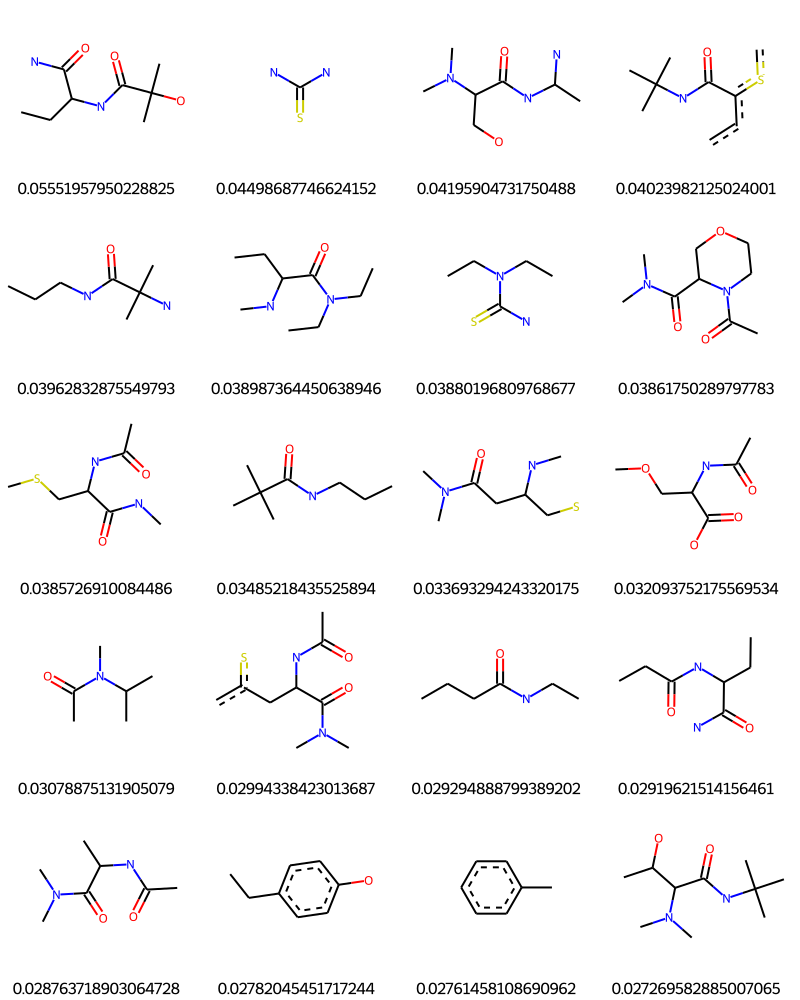

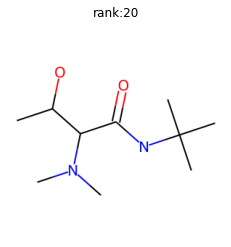

In [110]:
result = sorted(substruct_to_weight.items(),key=lambda x:(x[1],x[0]),reverse=True)
from rdkit.Chem import Draw
result_mols = []
result_scores = []
i = 0
for smi,score in result[:20]:
    i += 1
    # print(score.astype('str'))
    mol = Chem.MolFromSmarts(smi)
    result_mols.append(mol)
    result_scores.append(score.astype('str'))
    img = Draw.MolToImage(mol)
    plt.imshow(img)
    plt.xticks([])  # 去x坐标刻度
    plt.yticks([])  # 去y坐标刻度
    plt.axis('off')
    plt.title(f'rank:{i}')
    plt.savefig(os.path.join(f'../result/single_substucture/{i}.png'))

Draw.MolsToGridImage(result_mols,molsPerRow=4,subImgSize=(200,200),legends=result_scores)

In [111]:
for item in sorted(substruct_to_weight.items(), key=lambda x: submol_to_id[x[0]]):
    print(f'Substructure (SMARTS): {item[0]}')
    print()
    print(f'Weight: {item[1]}')
    print()
    print()

Substructure (SMARTS): [#6;D2;H1;R1;+0]:[#6;D3;H0;R2;+0]1:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D3;H0;R1;+0](-[#6;D2;H2;R0;+0]):[#6;D3;H0;R2;+0]:1

Weight: 0.021764705570698248


Substructure (SMARTS): [#35;D1;H0;R0;+0]-[#6;D3;H0;R1;+0]1:[#6;D2;H1;R1;+0]:[#6;D2;H1;R1;+0]:[#6;D3;H0;R2;+0](:[#6;D3;H0;R1;+0](-[#35;D1;H0;R0;+0]):[#6;D3;H0;R1;+0]):[#6;D3;H0;R2;+0](:[#6;D2;H1;R1;+0]):[#6;D2;H1;R1;+0]:1

Weight: 0.015438803436779449


Substructure (SMARTS): [#16;D2;H0;R0;+0]-[#6;D2;H2;R0;+0]-[#6;D3;H1;R0;+0](-[#6;D2;H2;R0;+0]-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#7;D3;H0;R1;+0](-[#6;D2;H2;R1;+0])-[#6;D3;H1;R1;+0])-[#7;D2;H1;R0;+0]-[#6;D3;H0;R0;+0]

Weight: 0.033693294243320175


Substructure (SMARTS): [#6;D2;H2;R1;+0]-[#6;D2;H2;R1;+0]-[#7;D3;H0;R1;+0](-[#6;D2;H2;R1;+0]-[#6;D2;H2;R1;+0])-[#6;D3;H0;R0;+0](=[#8;D1;H0;R0;+0])-[#6;D3;H1;R0;+0](-[#6;D2;H2;R0;+0]-[#6;D3;H0;R1;+0])-[#7;D2;H1;R0;+0]-[#6;D3;H0;R0;+0]

Weight: 0.038987364450638946


Substructure (SMARTS): [#17;D1;H0;R0;

### Plot substructure weights

In [112]:
substructs = sorted(substruct_to_weight.keys(), key=lambda s: submol_to_id[s])
weights = [substruct_to_weight[s] for s in substructs]
bars = []
for bit in bits_of_interest:
    _bars = []
    substruct_smarts_for_bit = submol_freq_distrib[bit].keys()
    for s in substructs:
        if s in substruct_smarts_for_bit:
            _bars.append(substruct_to_weight[s])
    bars.append(_bars)

print(bars)
print()
barWidth = 1.5
offset = 1.7
space = 4
pos = len(bars[0])*barWidth / 2
print(pos)

[[0.021764705570698248, 0.015438803436779449, 0.033693294243320175, 0.038987364450638946, 0.02530605128655831, 0.03962832875549793, 0.027269582885007065, 0.0385726910084486, 0.015009690076112747, 0.03861750289797783, 0.03880196809768677, 0.009046414867043495, 0.015981415286660194], [0.01736954005737224, 0.019196819678468504, 0.02782045451717244, 0.015954859255528225, 0.016323369078023675, 0.01909759711011644, 0.014022513803944963, 0.027267814860735314, 0.020779166074300356, 0.04498687746624152, 0.03078875131905079, 0.022168652154505253, 0.02492024004459381, 0.028763718903064728], [0.0140155673334068, 0.02761458108690962, 0.015436524412556808, 0.014434732267603514, 0.02919621514156461, 0.05551957950228825, 0.012622897540602614, 0.04023982125024001, 0.020320973979930084, 0.04195904731750488, 0.020894357934594154, 0.018812604248523712, 0.02030164934694767, 0.032093752175569534], [0.018101033647688163, 0.015626665328939755, 0.011015621945261955, 0.006399666657671332, 0.029294888799389202, 

In [113]:
r1 = [pos]
pos += space + 1.5*barWidth
r2 = [pos]
pos += space + 1.5*barWidth
r3 = [pos]
pos += space + 1.5*barWidth + (offset-barWidth)
r4 = [pos - barWidth - (offset-barWidth), pos, pos + barWidth + (offset-barWidth),pos + 2*barWidth + 2*(offset-barWidth),pos + 3*barWidth + 3*(offset-barWidth)]
pos += space + 5.5*barWidth + (offset-barWidth)
r5 = [pos - barWidth - (offset-barWidth), pos]
pos += space + 1.5*barWidth + (offset-barWidth)
r6 = [pos - barWidth - (offset-barWidth), pos]
# pos += space + 1.5*barWidth + (offset-barWidth)
# r7 = [pos]
# pos += space + 1.5*barWidth + (offset-barWidth)
# r8 = [pos]
rs = [r1, r2, r3, r4, r5, r6]

[[0.021764705570698248, 0.015438803436779449, 0.033693294243320175, 0.038987364450638946, 0.02530605128655831, 0.03962832875549793, 0.027269582885007065, 0.0385726910084486, 0.015009690076112747, 0.03861750289797783, 0.03880196809768677, 0.009046414867043495, 0.015981415286660194], [0.01736954005737224, 0.019196819678468504, 0.02782045451717244, 0.015954859255528225, 0.016323369078023675, 0.01909759711011644, 0.014022513803944963, 0.027267814860735314, 0.020779166074300356, 0.04498687746624152, 0.03078875131905079, 0.022168652154505253, 0.02492024004459381, 0.028763718903064728], [0.0140155673334068, 0.02761458108690962, 0.015436524412556808, 0.014434732267603514, 0.02919621514156461, 0.05551957950228825, 0.012622897540602614, 0.04023982125024001, 0.020320973979930084, 0.04195904731750488, 0.020894357934594154, 0.018812604248523712, 0.02030164934694767, 0.032093752175569534], [0.018101033647688163, 0.015626665328939755, 0.011015621945261955, 0.006399666657671332, 0.029294888799389202, 

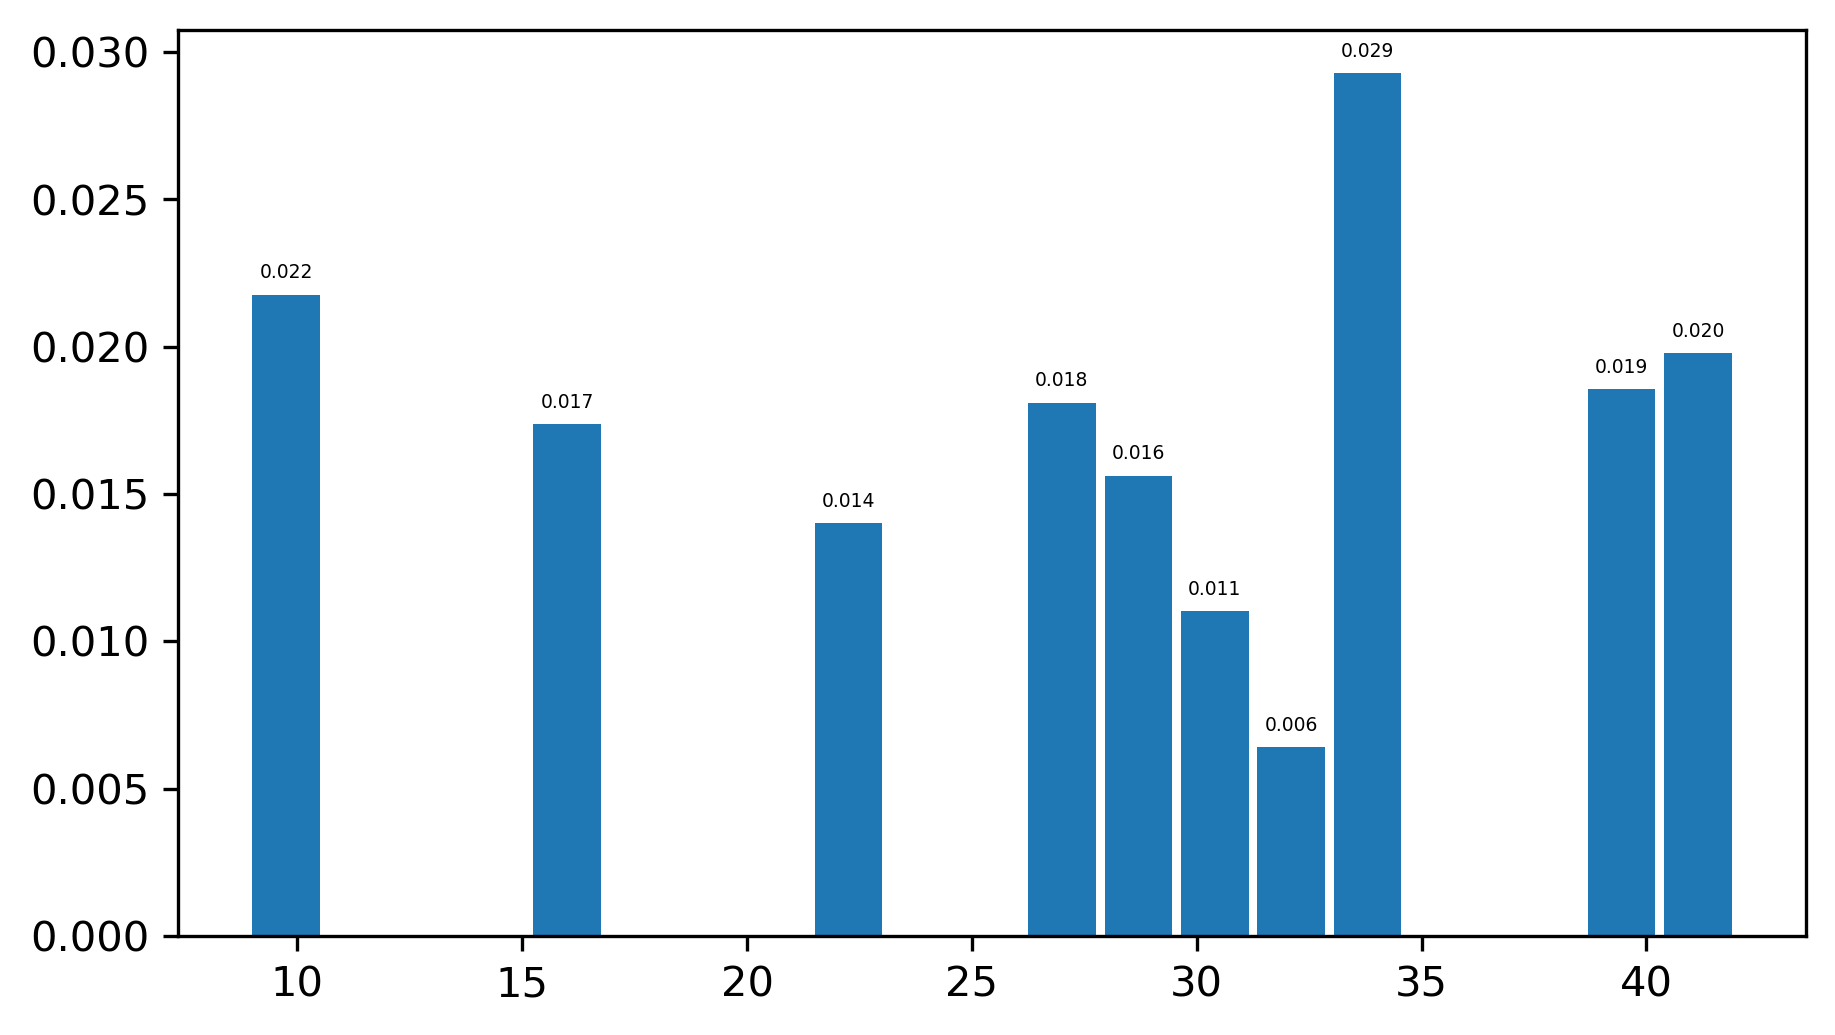

In [114]:
fig = plt.figure(figsize=(7, 4), dpi=300)

rects = []
print(bars)
print(rs)
for bit in range(len(bars[:5])):
    print('bit:',bit)
    for i in range(len(rs[bit])):
        print('i:',i)
        str = ("北京", "上海", "武汉", "深圳", "重庆")
        rects.append(plt.bar(rs[bit][i], bars[bit][i], color='#1f77b4',width=barWidth, zorder=2)[0])


for rect in rects:
    height = rect.get_height()
    plt.annotate('{:.3f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=4.5)

plt.savefig(pathify(f'substructure_weights_DD1S_CAIX_FP-FFNN_random_seed_0.png'))
plt.show()